# Predicting the Price of Diamonds

In this notebook, I explore data on diamonds, transform the data, and create a model that predicts diamond prices with 98.3% accuracy and an RMSE of around 350 to 395 on the test set (beating top submission on Kaggle for this task).

The data set can be found at https://www.kaggle.com/shivam2503/diamonds

# EXPLORING THE DATA



Features:
- carat: carat weight of the diamond (0.2--5.01)
- cut: cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)
- color: color diamond colour, from J (worst) to D (best)
- clarity: clarity a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
- depth: depth total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
- table: table width of top of diamond relative to widest point (43--95)
- price: price price in US dollars (\$326-$18,823)
- x: length in mm (0--10.74)
- y: width in mm (0--58.9)
- z: depth in mm (0--31.8)



In [1]:
import pandas as pd

df = pd.read_csv('diamonds.csv', index_col=0)
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [2]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


We can already see a problem with columns x, y, and z. They contain rows indicating the minimum length, width, or depth of the diamond is 0, which obviously can't be true. Let's drop these rows from the data set. 

In [3]:
def drop_rows(df, cols, val):
  if type(cols) is not list:
    cols = [cols]
  for i in cols:
    df.drop(index=df[df[i] == val].index, inplace=True)

drop_rows(df, ['x','y','z'], 0)
df.describe()

,carat,depth,table,price,x,y,z
count,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000,53920.000000
mean,0.797698,61.749514,57.456834,3930.993231,5.731627,5.734887,3.540046
std,0.473795,1.432331,2.234064,3987.280446,1.119423,1.140126,0.702530
min,0.200000,43.000000,43.000000,326.000000,3.730000,3.680000,1.070000
25%,0.400000,61.000000,56.000000,949.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5323.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [4]:
# Check for nan
df.isnull().sum()

carat      0
cut        0
color      0
clarity    0
depth      0
table      0
price      0
x          0
y          0
z          0
dtype: int64

Now let's visualize the distributions and correlations between numerical columns in the data set. 

We can see a strong correlation between price and carat, as well as between price and the x, y, z dimensions of a diamond. There are also outliers in various columns that we will want to handle. 

In [5]:
df.corr()['price'].sort_values(ascending=False)

price    1.000000
carat    0.921592
x        0.887231
z        0.868206
y        0.867864
table    0.127245
depth   -0.010729
Name: price, dtype: float64

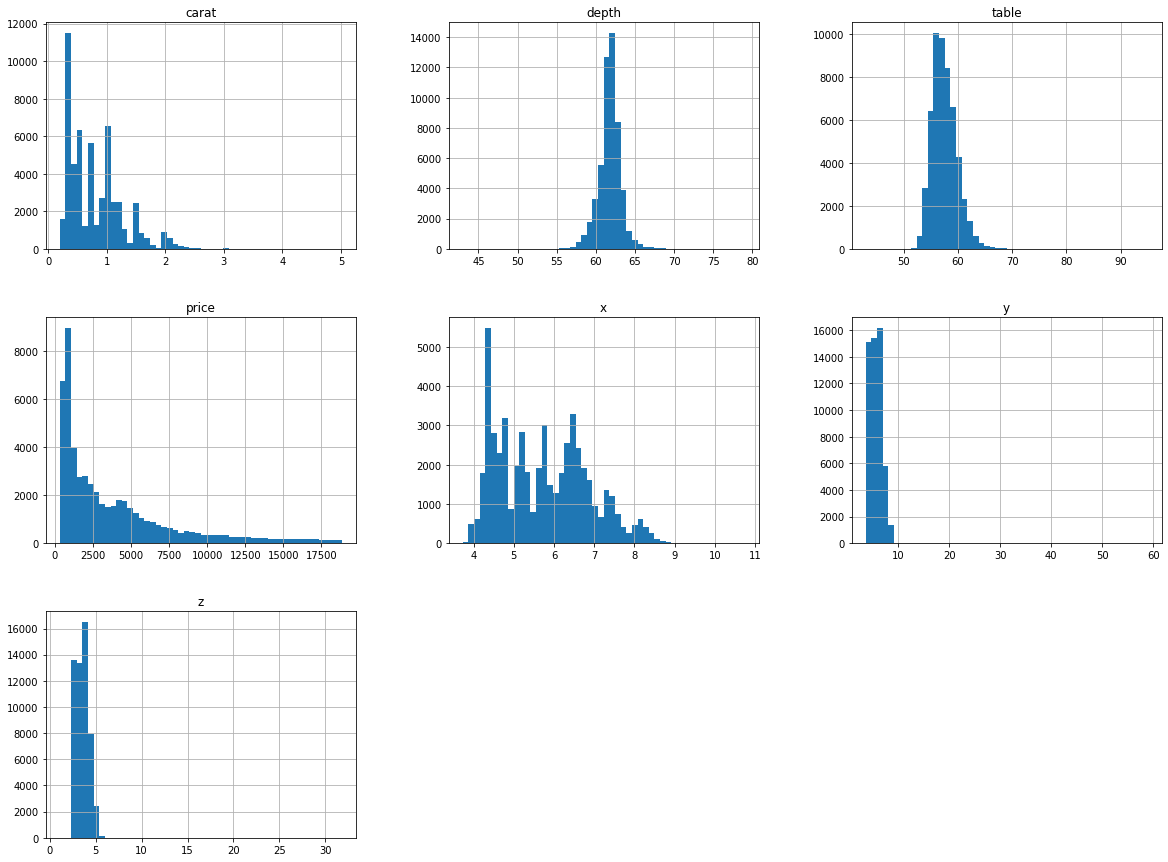

In [6]:
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

df.hist(bins=50, figsize=(20,15))
plt.show()

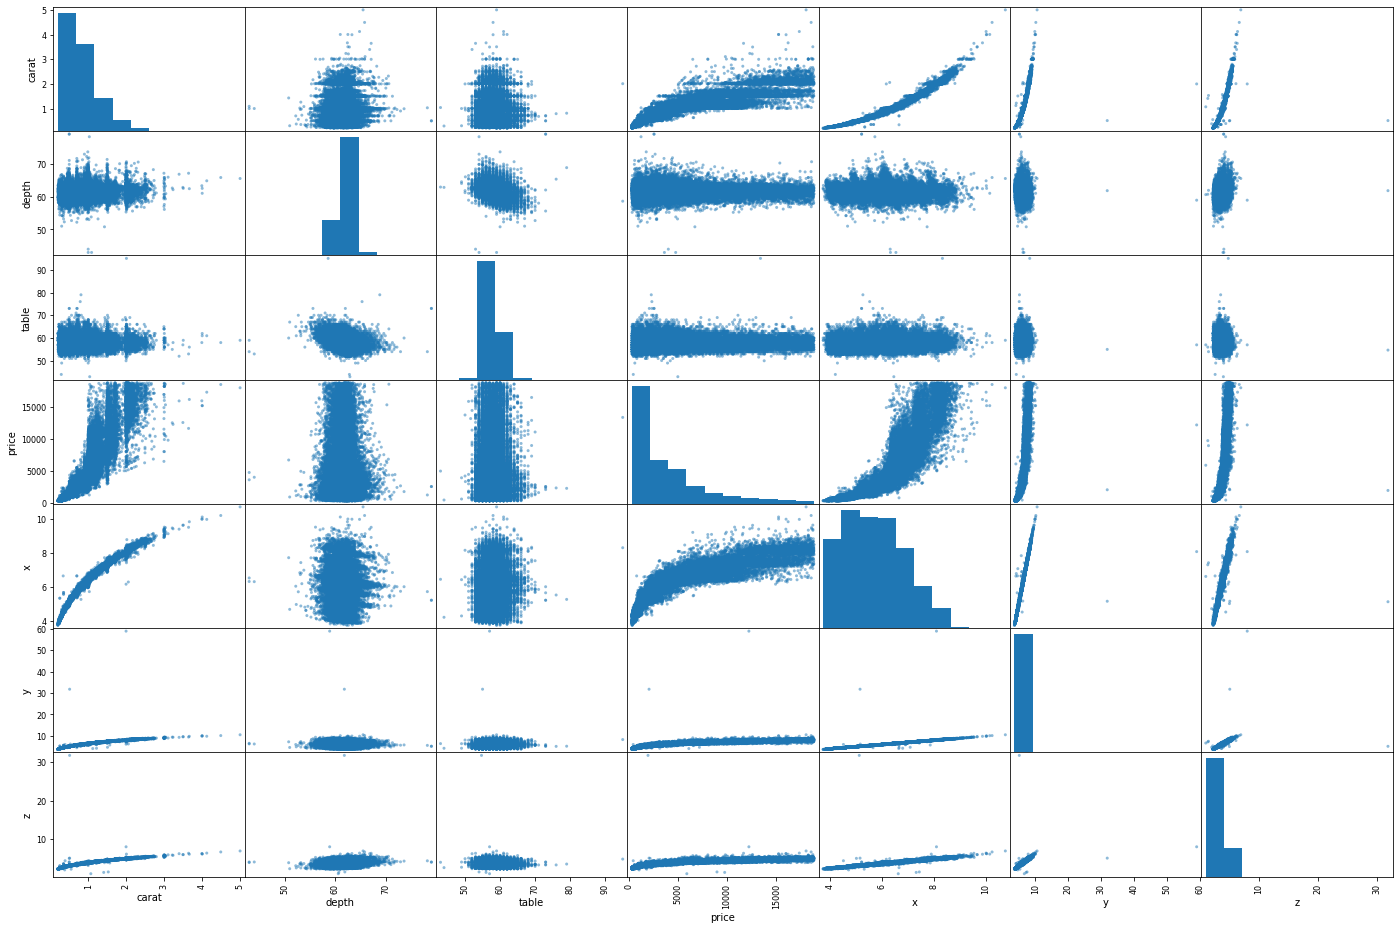

In [7]:
scatter_matrix(df[df.select_dtypes(['int', 'float']).keys()], figsize=(24, 16))
plt.show()

Let's use the interquartile method to remove outliers.

In [8]:
def remove_outliers(df):
  Q1 = df.quantile(0.25)
  Q3 = df.quantile(0.75)
  IQR=Q3-Q1
  return df[~((df<(Q1-1.5*IQR))|(df>(Q3+1.5*IQR))).any(axis=1)]

df = remove_outliers(df)

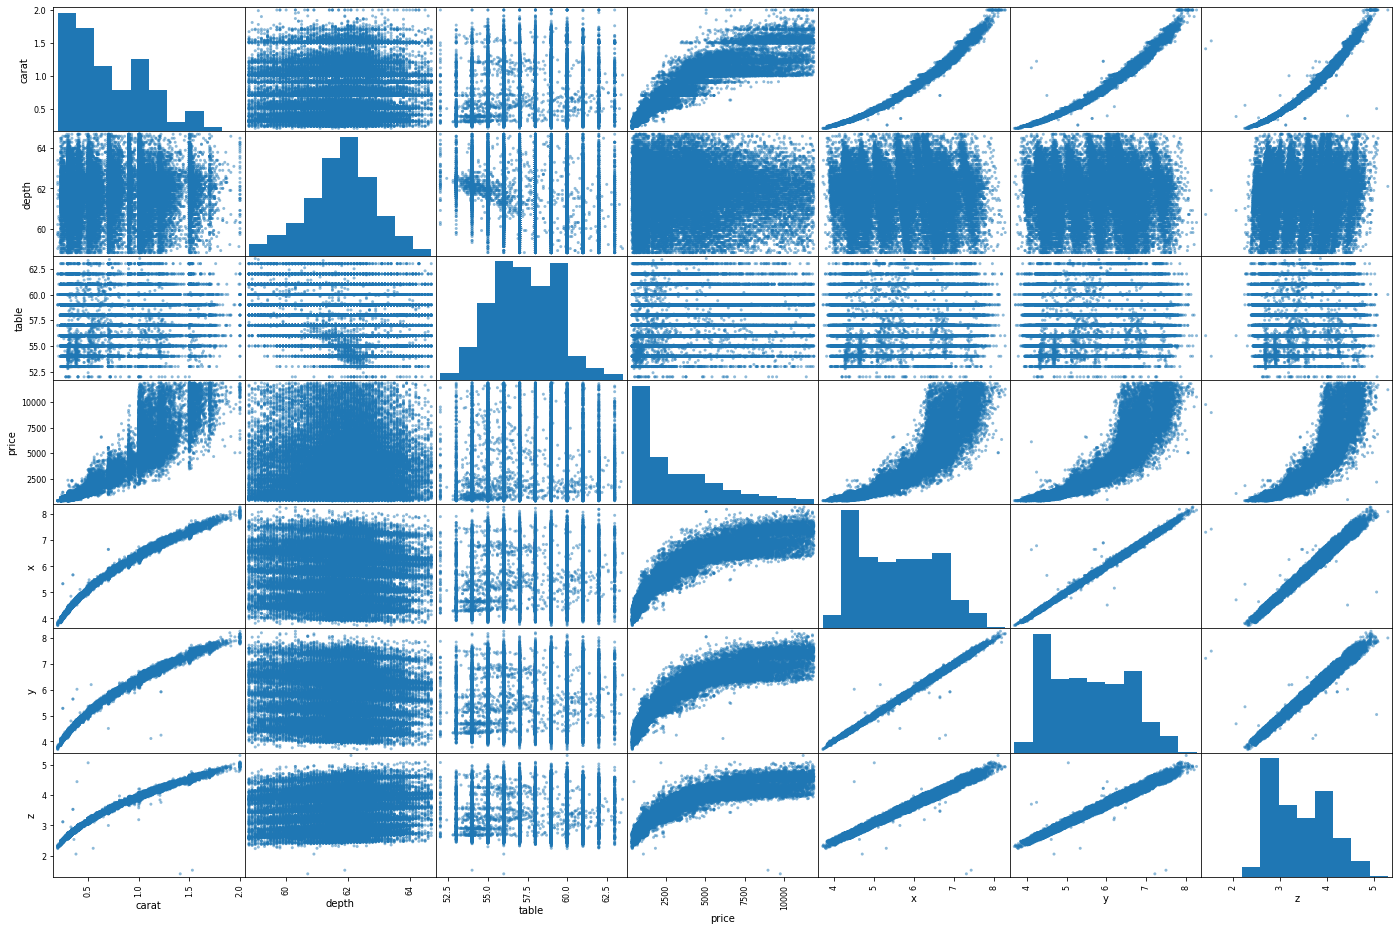

In [9]:
scatter_matrix(df[df.select_dtypes(['int', 'float']).keys()], figsize=(24, 16))
plt.show()

Now we will create a pipeline that normalizes the numerical columns and one-hot encodes the categorical columns. 

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# The price column is the only int type, so we can scale all float columns.
nums = df.select_dtypes(['float']).keys()
cats = df.select_dtypes(['object']).keys()
labels = df['price'].values

pipeline = ColumnTransformer([
    ('nums', MinMaxScaler(), nums),
    ('cats', OneHotEncoder(), cats),
  ])

# Create train and test sets.
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.2, random_state=11)
# Fit and transform train set.
X_train = pipeline.fit_transform(X_train)
# Transform test set on transformers fit to the train set.
X_test = pipeline.transform(X_test)

Next, we'll train different models to see which is the most promising for this task. We'll get the accuracy of each model on the test set and use ten folds in k-fold cross-validation and return an array of the root mean squared error for each fold to give us a better sense of the model's skill. 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
import numpy as np

def score_model(model, X_train, X_test, y_train, y_test):
  scores = cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
  rmse = np.sqrt(-scores)

  model.fit(X_train, y_train)
  return model.score(X_test, y_test), rmse

models = {
    'LINEAR': LinearRegression(), 
    'KNEIGHBORS': KNeighborsRegressor(), 
    'DECISION TREE': DecisionTreeRegressor(), 
    'RANDOM FOREST': RandomForestRegressor()
}

for model in models:
  score, rmse = score_model(models[model], X_train, X_test, y_train, y_test)
  print(model, f'Accuracy: {score}', f'RMSE: {rmse}', '\n', sep='\n')

LINEAR
Accuracy: 0.9265050391647036
RMSE: [728.4638326  748.34073145 764.19767244 738.36992919 742.45641985
 747.81776247 721.57369928 728.18503876 756.18781753 745.04631533]


KNEIGHBORS
Accuracy: 0.9579769011732556
RMSE: [528.8771216  553.65396742 560.4310991  569.07611153 593.16985421
 554.08172127 590.16182739 556.30036044 576.50105655 595.0531848 ]


DECISION TREE
Accuracy: 0.9678601251181153
RMSE: [483.44151768 519.63453868 483.05806813 480.7668122  506.18015621
 526.58293608 509.4965546  478.58353306 513.19084684 492.73187036]


RANDOM FOREST
Accuracy: 0.9828465085929556
RMSE: [354.52575572 368.6884934  351.64425201 370.61329712 375.24791448
 393.56454327 355.10730662 368.39866224 366.7216515  363.38858   ]




Finally, let's grid search some different parameters for the random forest model to see if there are any parameters that will further increase its skill.

In [12]:
from sklearn.model_selection import GridSearchCV

forest_reg = RandomForestRegressor()
param_grid = {
    'bootstrap': [True, False], 
    'n_estimators': [75,100,125], 
    'max_features': ['auto','sqrt','log2'],
  }

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, 
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

{'bootstrap': True, 'max_features': 'auto', 'n_estimators': 100}


The default model appears to be a good option for us.



# Conclusion

By removing data errors and outliers, scaling numerical columns and one-hot encoding categorical columns, we can achieve 98.3% accuracy with an RMSE around 350 to 395 when predicting diamond prices with a Random Forest Regressor model. 